In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('data/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [33]:
import nltk

STOP_WORDS = nltk.corpus.stopwords.words('english')

def preprocess(tweet):
    tweet = tf.keras.preprocessing.text.text_to_word_sequence(tweet)
    tweet = ['' if t in STOP_WORDS else t for t in tweet]
    return list(filter(None, tweet))

In [44]:
tweets = df.tweet

tweets_processed = [preprocess(t) for t in tweets]
tweets_processed = [" ".join(t) for t in tweets_processed]

**I use sent2vec embedding (https://github.com/epfml/sent2vec)**

In [45]:
import sent2vec

model = sent2vec.Sent2vecModel()
model.load_model('data/twitter_unigrams.bin') # sent2vec_twitter_unigrams 13GB (700dim, trained on english tweets)

In [85]:
X = model.embed_sentences(tweets_processed)
# X = tf.convert_to_tensor(X)
y = df['class']
# y = tf.one_hot(y, 3)

In [86]:
X.shape, y.shape

((24783, 700), (24783,))

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [88]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

y_train = tf.one_hot(y_train, 3)
y_test = tf.one_hot(y_test, 3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([19826, 700]),
 TensorShape([4957, 700]),
 TensorShape([19826, 3]),
 TensorShape([4957, 3]))

In [89]:
def build_model(input_shape):
    return tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax') # 3 classes
        ])

In [90]:
nn_model = build_model(X.shape[1])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               358912    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

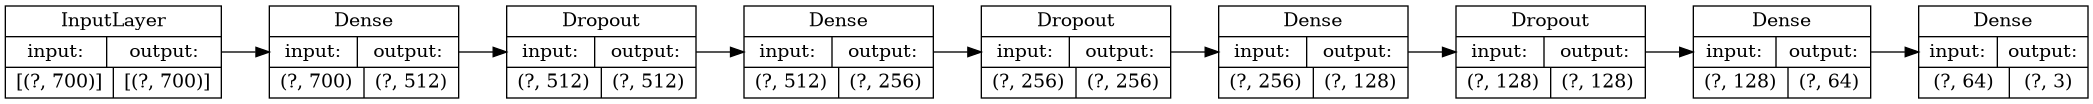

In [92]:
tf.keras.utils.plot_model(nn_model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [93]:
nn_model.fit(X_train,
             y_train,
             epochs=20,
             batch_size=128,
             validation_data=(X_test, y_test))

Train on 19826 samples, validate on 4957 samples
Epoch 1/20
19826/19826 [==============================] - 3s 166us/sample - loss: 0.3471 - accuracy: 0.8763 - val_loss: 0.2712 - val_accuracy: 0.9048
Epoch 2/20
19826/19826 [==============================] - 2s 109us/sample - loss: 0.2585 - accuracy: 0.9075 - val_loss: 0.2677 - val_accuracy: 0.9066
Epoch 3/20
19826/19826 [==============================] - 2s 112us/sample - loss: 0.2267 - accuracy: 0.9161 - val_loss: 0.2744 - val_accuracy: 0.9066
Epoch 4/20
19826/19826 [==============================] - 2s 113us/sample - loss: 0.2026 - accuracy: 0.9241 - val_loss: 0.2850 - val_accuracy: 0.9042
Epoch 5/20
19826/19826 [==============================] - 4s 189us/sample - loss: 0.1663 - accuracy: 0.9363 - val_loss: 0.3430 - val_accuracy: 0.9007
Epoch 6/20
19826/19826 [==============================] - 3s 173us/sample - loss: 0.1504 - accuracy: 0.9407 - val_loss: 0.3424 - val_accuracy: 0.9022
Epoch 7/20
19826/19826 [===========================

In [98]:
import numpy as np

y_preds = np.argmax(nn_model.predict(X_test), axis=1)

In [103]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.49      0.20      0.29       295
           1       0.93      0.95      0.94      3814
           2       0.81      0.90      0.85       848

    accuracy                           0.89      4957
   macro avg       0.74      0.68      0.69      4957
weighted avg       0.88      0.89      0.88      4957

